In [3]:
import xarray as xr
import xclim

import matplotlib.pyplot as plt

#########################################################################################################################################

def jun_total(ts):
    
    jt = ts.resample(time = "MS").sum().groupby("time.month")[6]
    jt = xclim.core.calendar.convert_calendar(jt, "default", align_on = "date")
    return jt

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def anom_diff_ts(ts, sm = 15, t_0 = 0):
    
    # t_0 is start of year used for accumulation of anomalies (should be in middle of dry season - default is to start from beginning of calendar year)
    # sm is number of days used to smooth the anomalies (default is 15, ie day +- 7 days)
    
    # wrap year at t_0 by shifting all values forwards
    ts = ts.shift(time = -t_0)
    
    # daily anomaly wrt annual mean
    anom = ts.groupby("time.year") - ts.groupby("time.year").mean("time")
       
    # cumulative daily anomalies each year
    anom_cum = anom.groupby("time.year").cumsum()
    
    # smooth the cumulative anomalies
    anom_sm = anom_cum.rolling(time = sm, center = True).mean()
    
    # differences of smoothed anomalies
    anom_diff = anom_sm.diff("time")
    
    # push the anomalies back to have the correct dates
    anom_diff = anom_diff.shift(time = t_0)
    
    return anom_diff


def rainy_season(ts, sm = 15, t_0 = 0):
        
    # get differences of smoothed anomalies
    anom_ts = anom_diff_ts(ts, sm = sm, t_0 = t_0)
    
    # count number of consecutive days of positive gradient in cumulative precip
    rs_length = xclim.indices.run_length.rle(xr.ones_like(anom_ts).where(anom_ts > 0, 0))
    
    # tag all days with length of period to which they belong
    rs_length = rs_length.ffill("time")
    
    # identify those days that are part of the longest wet period in each year
    rs = rs_length.where(rs_length.groupby("time.year") - rs_length.groupby("time.year").max() == 0)
        
    # convert calendar to Gregorian, matching dates (ensures that DOY is correct, regardless of model calendar)
    rs = xclim.core.calendar.convert_calendar(rs, "default", align_on = "date")
    
    # get start & end of rainy season
    onsets = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").min().dt.dayofyear
    ends = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").max().dt.dayofyear
    
    # duration of rainy season
    durations = ends - onsets
    
    return onsets, ends, durations

In [4]:
# load obs, drop missing values, select only dates to end of 2021
chirps = xr.open_dataset("obs/ichirps_20_25_-3-24E_14-16N_n.nc").precip.dropna("time", "any").sel(time = slice(None, "20211231"))

june_totals = jun_total(chirps)
onsets, ends, durations = rainy_season(chirps, sm = 15, t_0 = 0)

Text(0.5, 1.0, 'Anomaly in total June precip')

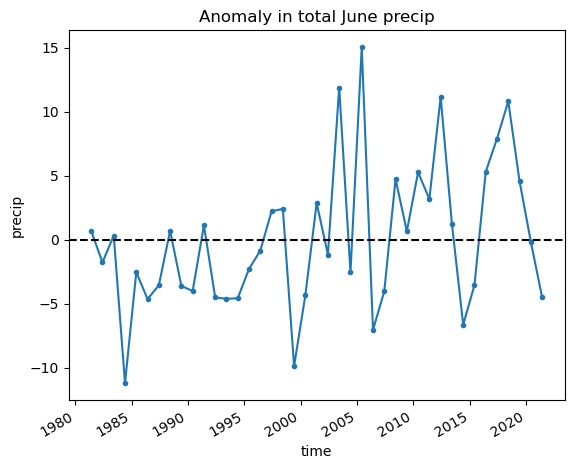

In [5]:
(june_totals - june_totals.mean()).plot(marker = ".")
plt.axhline(0, ls = "--", color = "k")
plt.title("Anomaly in total June precip")

In [7]:
(june_totals - june_totals.mean()).sel(time = "2021")

<xarray.DataArray 'precip' (time: 1)>
array([-4.500471], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-06-01

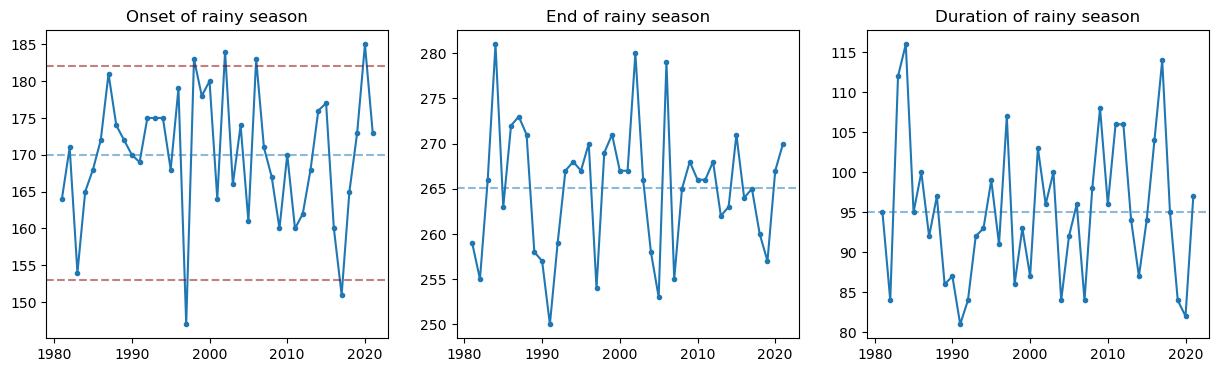

In [26]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (15,4), dpi = 100, facecolor = "w")

axs[0].plot(onsets.year, onsets, marker = ".")
axs[0].axhline(onsets.mean(), ls = "--", alpha = 0.5)
axs[0].set_title("Onset of rainy season")

axs[1].plot(ends.year, ends, marker = ".")
axs[1].axhline(ends.mean(), ls = "--", alpha = 0.5)
axs[1].set_title("End of rainy season")

axs[2].plot(durations.year, durations, marker = ".")
axs[2].axhline(durations.mean(), ls = "--", alpha = 0.5)
axs[2].set_title("Duration of rainy season")

jun_doy = chirps.sel(time = ["20200601", "20200630"]).time.dt.dayofyear.values
axs[0].axhline(jun_doy[0], color = "darkred", ls = "--", alpha = 0.5)
axs[0].axhline(jun_doy[1], color = "darkred", ls = "--", alpha = 0.5)
